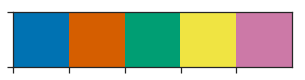

In [1]:
import sys
import os
from glob import glob
import random
import itertools as it
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import pysam
import pybedtools as pybt

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=1.4, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [202]:
from ushuffle import shuffle as ushuffle

RC = str.maketrans('ACGTSWRYN', 'TGCASWYRN')


def rev_comp(seq):
    return seq.translate(RC)[::-1]


def motif_count(seqs, motifs, motif_len):
    kmer_pos_count = defaultdict(lambda: np.zeros(shape=len(seqs[0])))
    for seq in seqs:
        assert len(seq) == len(seqs[0]), 'All seqs should be uniform length'
        for i in range(len(seq) - motif_len + 1):
            kmer = seq[i: i + motif_len]
            if kmer in motifs:
                kmer_pos_count[kmer][i: i + motif_len] += 1
    return np.array([kmer_pos_count[k] for k in motifs])


def permute_seqs(seqs, w):
    shuf_seqs = []
    for seq in seqs:
        shuf = ushuffle(seq.encode(), w).decode()
        shuf_seqs.append(shuf)
    return shuf_seqs


def motif_enrichment(seqs, w, n_perm, motifs, motif_len):
    obs = motif_count(seqs, motifs, motif_len)
    exp = []
    for _ in range(n_perm):
        shuf_seqs = permute_seqs(seqs, w)
        exp.append(motif_count(shuf_seqs, motifs, motif_len))
    exp = np.array(exp)
    enrichment = np.log2(obs.sum(0) + 0.5) - np.log2(exp.sum(1) + 0.5)
    return enrichment

In [263]:
CANON_PAS = 'AATAAA'
PAS_KMERS = set([CANON_PAS])
for i, n in it.product(range(6), 'ACGT'):
    kmer = CANON_PAS[:i] + n + CANON_PAS[i + 1:]
    if not kmer == 'AAAAAA':
        PAS_KMERS.add(kmer)
PAS_KMERS = list(PAS_KMERS)

In [264]:
def get_pas_enrichment(der_sites_fn, fasta_fn, w, n_perm):
    seqs = []
    with pysam.FastaFile(fasta_fn) as fasta, open(der_sites_fn) as gtf:
        for record in gtf:
            record = record.split()
            pos = ((int(record[3]) - 1) + int(record[4])) // 2
            chrom = record[0]
            strand = record[6]
            seq = fasta.fetch(chrom, pos - 50, pos + 51)
            if strand == '-':
                seq = rev_comp(seq)
            seqs.append(seq)
    seqs = list(set(seqs))
    pas_enrichment = {}
    for motif in PAS_KMERS:
        pas_enrichment[motif] = motif_enrichment(seqs, w, n_perm, [motif,], 6)
    m6a_enrichment = motif_enrichment(seqs, w, n_perm, M6A_MOTIFS, 5)
    return pas_enrichment, m6a_enrichment, seqs

In [256]:
pas_enrichment, m6a_enrichment, seqs = get_pas_enrichment(
    '/cluster/ggs_lab/mtparker/DER_m6a_pipeline_runs/vir1_VIRc_guppy/motif_detection/der_motifs.gtf',
    '/cluster/ggs_lab/mtparker/Arabidopsis_annotations/TAIR10/ensembl/release_35/Arabidopsis_thaliana.TAIR10.dna.toplevel.fa',
    w=2, n_perm=100
)

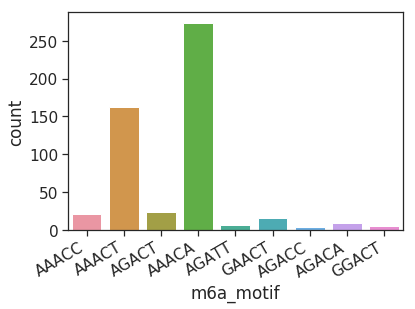

In [330]:
seqs_df = pd.Series(seqs).to_frame()
seqs_df.columns = ['full_seq']
seqs_df['m6a_motif'] = seqs_df.full_seq.str[48:53]
seqs_df['has_overlapping_PAS'] = seqs_df.full_seq.str[45:56].str.contains('|'.join(PAS_KMERS))
ax = sns.countplot(seqs_df[seqs_df.has_overlapping_PAS]['m6a_motif'])
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.show()

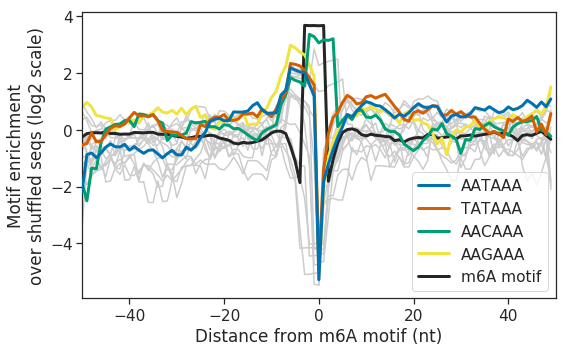

In [357]:
fig, ax = plt.subplots(figsize=(8, 5))
for k, v in pas_enrichment.items():
    ax.plot(np.arange(-51, 50), v.mean(0), color='#cccccc', zorder=-1)
ax.plot(np.arange(-51, 50), pas_enrichment['AATAAA'].mean(0), label='AATAAA', color=pal[0], lw=3, zorder=5)
ax.plot(np.arange(-51, 50), pas_enrichment['TATAAA'].mean(0), label='TATAAA', color=pal[1], lw=3, zorder=4)
ax.plot(np.arange(-51, 50), pas_enrichment['AACAAA'].mean(0), label='AACAAA', color=pal[2], lw=3, zorder=2)
ax.plot(np.arange(-51, 50), pas_enrichment['AAGAAA'].mean(0), label='AAGAAA', color=pal[3], lw=3, zorder=1)
ax.plot(np.arange(-51, 50), m6a_enrichment.mean(0), label='m6A motif', color='#252525', lw=3, zorder=0)
ax.legend()
ax.set_xlabel('Distance from m6A motif (nt)')
ax.set_ylabel('Motif enrichment\nover shuffled seqs (log2 scale)')
ax.set_xlim(-50, 50)
plt.tight_layout()
plt.savefig('pas_sequence_enrichement.svg')
plt.show()